In [1]:
import os
import glob

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
#### LinearSVC allows for easy retrieval of the most important features and it is 
#### more efficient, because it is an optimized version of SVC with linear kernel,
#### shortening runtime. Thus, LinearSVC is used for all of the experiments below.
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
authors = set('BRULIN CLAUS HERMANS KOECK MICHIELS MULISCH'.split())
print(authors)

genres = ['Essays', 'Proza', 'Toneel']

{'CLAUS', 'HERMANS', 'BRULIN', 'MICHIELS', 'KOECK', 'MULISCH'}


In [3]:
segment_length = 1000

In [4]:
import nltk
from nltk.tokenize import word_tokenize

## segment text funtion (remainder is dropped if n tokens is less than 'segment_length')
def segment_text(text, segment_size):
    #tokens = text.strip().split()
    tokens = nltk.tokenize.word_tokenize(text, language='dutch') ## use "better" tokenizer
    segments = []
    si, ei = 0, segment_size
    while ei <= len(tokens):
        segments.append(' '.join(tokens[si:ei]))
        si += segment_size
        ei += segment_size
    return segments

In [5]:
data = []

for author_dir in os.listdir('data'):
    if author_dir not in authors:
        continue
    for genre_dir in os.listdir(f'data/{author_dir}'):
        if genre_dir not in genres:
            continue
        for fn in glob.glob(f'data/{author_dir}/{genre_dir}/*.txt'):
            parts = os.path.basename(fn).replace('.txt', '').split('_')
            date, textname = parts[0], parts[-1].lower()
            try:
                
            ## "errors='ignore'" preserves special characters as in: "één, vóór", etc.
            ## In addition, this resolves some encoding issues and prevents some errors
            
                with open(fn, encoding='utf8', errors='ignore') as f:
                    text = f.read()
            except UnicodeDecodeError:
                continue
            
            ## manually cleaned texts by removing all mentions of author names from texts,
            ## as well as removing some footnotes, disclaimers, non-authorial prefaces, etc.            segments = segment_text(text, segment_length)
            
            segments = segment_text(text, segment_length)
            if not segments:
                continue
            for idx, segment in enumerate(segments):
                data.append((author_dir, genre_dir, textname, segment, idx + 1))

In [6]:
corpus = pd.DataFrame(data, columns=('author', 'genre', 'title', 'segment', 'idx'))
corpus.sample(10)

,author,genre,title,segment,idx
503,CLAUS,Proza,hondsdagen,weggetje af met het strikt noodzakelijke en vo...,39
2892,KOECK,Proza,vrijeval,en de geur van leer . Het was na schooltijd . ...,25
1609,CLAUS,Toneel,ineenhaven,"u , Colonel . mimi Ja , Angele bekende mij haa...",2
1911,BRULIN,Toneel,mikroben,je zoon ? ... DE MOEDER ZONDER TE ANTWOORDEN V...,14
1631,CLAUS,Toneel,oedipus,geen wet die dit bed kan verbranden met zijn w...,8
3114,KOECK,Proza,exemplaren,. Ik werd goed ontvangen . Ik heb toen zijn ka...,80
3005,KOECK,Proza,irishmist,"het , niks tegen je zin , ' zei Helena . Maar ...",95
1639,CLAUS,Toneel,degetuigen,hen een dolk van Duitse makelij zien ... pruus...,3
884,CLAUS,Proza,verwondering,de heren en dames van Almout . Nu hang ik van ...,32
2215,HERMANS,Proza,nooitmeerslapen,Zo'n sherpa neemt zijn sahib desnoods op de ru...,65


## Genre classification with "leave-one-text-out" cross-validation

In [7]:
all_genres = corpus.copy()
all_genres.sample(5)

,author,genre,title,segment,idx
3176,KOECK,Toneel,bewustmaker,niet . Ze steekt het licht aan . Hij wendt zic...,18
3209,KOECK,Toneel,depaniekzaaier,Ik ... Burat Ha zo ! We komen al dichter bij d...,5
1617,CLAUS,Toneel,orestes,je tenminste in het gevecht . orestes Zij zull...,8
924,CLAUS,Proza,verwondering,"probeerde op te zoeken , maar hij dacht : ' La...",72
2445,HERMANS,Toneel,test,! Zij heeft haar tijd aan mij verknoeid ! Niet...,18


In [8]:
texts = set(all_genres['title'])
print(len(texts)) ## added Michiels' essays from the 'Handelsblad' folder (= 121 more texts)
print('\t')
print(texts)

181
	
{'nooitmeerslapen', 'destenenhebbeneenziel', 'hetboek', 'heinzrisse', 'liedvandemoordenaar', 'ernestclaes', 'zaakpeejee', 'engelbewaarder', 'bruidindemorgen', 'kaarsenbril', 'zwaardvis', 'willemelsschot', 'achdukleineswernerlein', 'bezoekuur', 'horizontaal', 'nederlandseverhalen', 'keesmeekel', 'elsschot', 'kroniekproza', 'dewereld', 'hoelaatishet', 'lagerkvist', 'terugnaarhetboek', 'twijfelentraan', 'exemplaren', 'memoiresenkortverhalen', 'jamesjones', 'vandijck', 'historischeromans', 'belladonna', 'debijbel', 'madeliefjes', 'spiegel', 'morituri', 'samuelosamuel', 'tanchelijn', 'deedee', 'wreedheid', 'tweeisteweinigdrieisteveel', 'kingkong', 'deboekenbeurs', 'bazilaire', 'juliengreen', 'grahamgreene', 'jessica!', 'romandebuten', 'grahamgreen', 'gevecht', 'eennieuwelente', 'ouderenenjongere', 'vlek', 'vertelkunst', 'vernieling', 'generatie', 'dixit', 'authenticiteit', 'hetboekalfa', 'boon', 'nederlandsevertaling', 'carlococcioli', 'posada', 'nuhetdorpnietmeerbestaat', 'faulkner2'

In [9]:
## check class distributions
all_genres_dist=all_genres[['genre','segment']].groupby('genre').count().reset_index()
all_genres_dist.columns=['genre','count']
all_genres_dist['percentage']=(all_genres_dist['count']/all_genres_dist['count'].sum())*100
all_genres_dist

,genre,count,percentage
0,Essays,603,18.261660
1,Proza,2087,63.204119
2,Toneel,612,18.534222


In [10]:
## randomly downsample to lowest n segments of the minority class
all_genres = all_genres.groupby('genre', group_keys=False).apply(lambda x: x.sample(603))
## Note: the above code may result in some errors, so you may have to rerun it a few times

## re-check class distributions
all_genres_dist=all_genres[['genre','segment']].groupby('genre').count().reset_index()
all_genres_dist.columns=['genre','count']
all_genres_dist['percentage']=(all_genres_dist['count']/all_genres_dist['count'].sum())*100
all_genres_dist

,genre,count,percentage
0,Essays,603,33.333333
1,Proza,603,33.333333
2,Toneel,603,33.333333


              precision    recall  f1-score   support

      Essays       0.85      0.86      0.85       603
       Proza       0.70      0.87      0.77       603
      Toneel       0.94      0.69      0.80       603

    accuracy                           0.81      1809
   macro avg       0.83      0.81      0.81      1809
weighted avg       0.83      0.81      0.81      1809

	
Macro F1-score: 0.8083949582860916
	


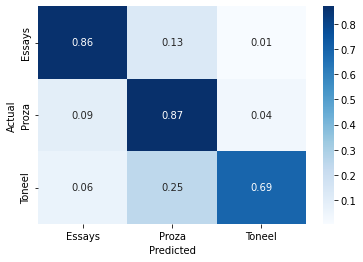

	
Top 100 most important/discrminative/characteristic TF-IDF weighted word 1-grams per genre:
	
Essays:	 van, ook, reich, freud, één, later, wordt, wanneer, pierre, appel, weinreb, eigen, jaar, schrijver, la, die, schilder, boek, in, mexico, wel, bijvoorbeeld, neen, uit, eddie, kunst, doch, dichter, leven, werd, dieren, voor, spelling, zin, frans, schrijft, kennen, taal, boeken, zelf, roepen, deze, eerste, vind, ruimte, der, liet, bij, vrouw, lezen, le, jaren, tot, maar, nederland, ergens, sinds, staat, eeuw, worden, literatuur, verhaal, soms, waarin, nauwelijks, roman, nederlandse, manier, nederlands, toch, na, schrijvers, zoek, zo, geschreven, niks, inderdaad, doek, stad, gingen, betreft, minder, bovendien, en, natuurlijk, vinden, antwerpen, dit, werkelijkheid, bepaald, waarmee, gewoon, tuin, politie, les, nieuwe, vorm, natuur, weinig, the

Proza:	 zegt, zei, gustaaf, haar, kon, dacht, hij, riep, louis, alberegt, water, foto, dank, zou, onze, ogen, steen, generaal, ge, lang, en, mij,

In [11]:
gold, silver = [], []

for text in texts:
    #print(text)
    train_df = all_genres[all_genres['title'] != text]
    test_df = all_genres[all_genres['title'] == text]
    
    ## word 1-grams (not char 3-grams) to make the most important features interpretable
    vectorizer = TfidfVectorizer(max_features=1000, lowercase=True) ## 'False' = more acc.
    ## empty samples if 'max_features' =/= 'segment_length' !
        
    vectorizer.fit(train_df['segment'])
    
    train_X = vectorizer.transform(train_df['segment'])
    train_y = train_df['genre']
    
    test_X = vectorizer.transform(test_df['segment'])
    test_y = test_df['genre']
    
    genre_clf = LinearSVC(random_state=42).fit(train_X, train_y)
    
    gold.extend(test_y)
    silver.extend(genre_clf.predict(test_X))
    
    
assert len(gold) == len(silver)

print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score: {f1_score(gold, silver, average='macro')}")
print('\t')

genre_cm = confusion_matrix(gold, silver)

## normalize
genre_cmn = genre_cm.astype('float') / genre_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(genre_cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=genre_clf.classes_, yticklabels=genre_clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('genre_classification_cmn.png', bbox_inches='tight')
plt.show(block=False);


def print_top_feats(vectorizer, genre_clf, class_labels):
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_feats = np.argsort(genre_clf.coef_[i])[-100:][::-1] ## Top X (100) featsb per genre
        print('%s:\t %s\n' % (class_label,
              ', '.join(feature_names[j] for j in top_feats)))

print('\t')
print('Top 100 most important/discrminative/characteristic TF-IDF weighted word 1-grams per genre:')
print('\t')
print_top_feats(vectorizer, genre_clf, genre_clf.classes_)

**Most interesting approaches include removing proper nouns/ names of characters (using NER for instance), as well as restricting the vocablary to a carefully composed list of function words, thus excluding proper names, pronouns, and other features related to genre/topic/content/demographic rather than authorial style; etc.**

In [12]:
### The below alternative is simple yet effective, except it returns indices, not the tokens
#pd.Series(abs(svm.coef_[0])).nlargest(100).plot(kind='barh', figsize=(15,30));

### Intra-Genre Experiments

In [13]:
intra_genre = corpus.copy()
#intra_genre.sample(5)

In [15]:
## check class distributions
intra_genre_dist=intra_genre[['author','segment']].groupby('author').count().reset_index()
intra_genre_dist.columns=['author','count']
intra_genre_dist['percentage']=(intra_genre_dist['count']/intra_genre_dist['count'].sum())*100
intra_genre_dist

,author,count,percentage
0,BRULIN,278,8.419140
1,CLAUS,1311,39.703210
2,HERMANS,544,16.474864
3,KOECK,508,15.384615
4,MICHIELS,307,9.297396
5,MULISCH,354,10.720775


In [16]:
## randomly downsample to lowest n segments of the minority class
intra_genre = intra_genre.groupby('author', group_keys=False).apply(lambda x: x.sample(278))
## Note: the above code may result in some errors, so you may have to rerun it a few times

## re-check class distributions
intra_genre_dist=intra_genre[['author','segment']].groupby('author').count().reset_index()
intra_genre_dist.columns=['author','count']
intra_genre_dist['percentage']=(intra_genre_dist['count']/intra_genre_dist['count'].sum())*100
intra_genre_dist

,author,count,percentage
0,BRULIN,278,16.666667
1,CLAUS,278,16.666667
2,HERMANS,278,16.666667
3,KOECK,278,16.666667
4,MICHIELS,278,16.666667
5,MULISCH,278,16.666667


### Intra-genre: Proza

              precision    recall  f1-score   support

      BRULIN       0.61      0.82      0.70       126
       CLAUS       0.75      0.97      0.84       219
     HERMANS       0.40      0.30      0.34       153
       KOECK       0.72      0.39      0.51       167
    MICHIELS       0.78      0.80      0.79       113
     MULISCH       0.59      0.61      0.60       165

    accuracy                           0.65       943
   macro avg       0.64      0.65      0.63       943
weighted avg       0.64      0.65      0.63       943

	
Macro F1-score Proza -> Proza: 0.6290024084002775
	


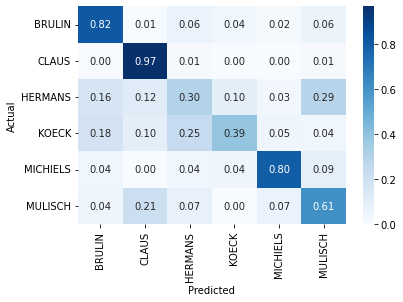

	
100 most important/characteristic TF-IDF weighted character 3-grams per author for Proza:
	
BRULIN:	  . , n .,  ( ,  ) , van,  va, . e, . ', en ,  ee, me ,  je,  on, ie , . m, de , . z, an , e v, , d,  be,  pi,  za, hem, em ,  ma,  he, n v, ke , als, nge, was,  en, as , . h, t .,  ve, e b,  me, we , dro,  sp, ls ,  ! , ze , ikk, ver, mer, pie, ach, cht, ake, rst, ing, dig,  po, om , os , ied, zal, heb, e o, : ', e g, g ., bes, bew,  .., .. , had, se , baa, zak, eid,  to, oer, t j, ge , s e, dra, dac, on , rot, oos,  bl, ont,  'i, rom, een, den, ch , spr, ! ', ben, eb , erb, erl, wie, ht , e z

CLAUS:	  ' , ij , zij,  , ,  zi, ' d, ge ,  ge,  in, van, e ,,  va, ' h,  sc,  lo, ft , rig, , i, eft, is ,  wi, ter, in , ren, ari, el , uis, eef, auw,  vl, nge, ler, n i, rie, ' z, n d, wan, nze,  ro, ran, rs , zeg, tte, j h, dit, ons,  ti, , h, ers, ls ,  on, e l, tje, t g, j z, ong, ie , , g,  ja, ine, kla, , a, n h,  ha, t z, ors,  co, onz, mij, . z,  ka, lag, jon, r ., haa, oet,  la,  ma,

In [19]:
proza = intra_genre[intra_genre['genre']=='Proza']
texts = set(proza['title'])

gold, silver = [], []

for text in texts:
    #print(text)
    train_df = proza[proza['title'] != text]
    test_df = proza[proza['title'] == text]
    
    vectorizer = TfidfVectorizer(max_features=1000, 
                                 analyzer='char',
                                 ngram_range=(3,3),
                                 min_df = 5).fit(train_df['segment'])
                                 ## empty samples if 'max_features' =/= 'segment_length' !
        
    vectorizer.fit(train_df['segment'])
    
    train_X = vectorizer.transform(train_df['segment'])
    train_y = train_df['author']
    
    test_X = vectorizer.transform(test_df['segment'])
    test_y = test_df['author']
    
    clf = LinearSVC(random_state=42).fit(train_X, train_y)
    
    gold.extend(test_y)
    silver.extend(clf.predict(test_X))
    

assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Proza -> Proza: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('intra_proza.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important/characteristic TF-IDF weighted character 3-grams per author for Proza:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**Note: best performance so far. Clearly, intra-genre AA yields better results compared to the cross-genre cases, as controlling for genre in a singe-genre setting eliminates potential noise/interference from other genres.**

### Intra-genre: Toneel

              precision    recall  f1-score   support

      BRULIN       0.59      0.96      0.73       138
       CLAUS       0.76      0.93      0.84        41
     HERMANS       0.50      0.19      0.27        32
       KOECK       0.79      0.36      0.50        75
    MICHIELS       0.83      0.68      0.75        28
     MULISCH       0.75      0.31      0.43        49

    accuracy                           0.66       363
   macro avg       0.70      0.57      0.59       363
weighted avg       0.68      0.66      0.62       363

	
Macro F1-score Toneel -> Toneel: 0.5863320382790663
	


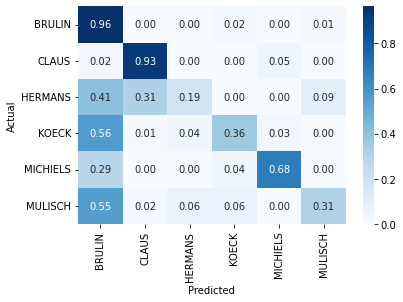

	
100 most important/characteristic TF-IDF weighted character 3-grams per author for Toneel:
	
BRULIN:	 . (, en ,  po, r :, rne, ..., le , ern,  : , kur,  je, t :, me ,  ( ,  ga,  ) , ner, .. ,  ..,  be, n .,  kl, rie, uto, ale, . g, ere, de , ing, lin, ees, hei, ies,  en, wer, wis, ank,  me, lde, hil,  ee, dre, . k, enk, urt, oit, n v,  ka, gee, is ,  fr,  u , kar, rli,  mi, ris, . l, ele, kam, mis, as ,  lo, per, art, iek,  ja, den,  ik,  an,  du,  se, eur, ek , ein, ull, les, . ), ers, jk ,  di, . p, zel,  pe, erl, er ,  is, lot, n j, ie , : w, ijs,  sp, : j, ee , il ,  va, een,  on, spi, bew

CLAUS:	  [ ,  ] ,  , , ij , moe, rma,  mo, de , oer, zij, mij,  zi, erm,  mi, jon,  en, der, ild, n ,, e j, oed, dre, man, ong, vad,  ou, e m,  jo,  ba, . d,  ho, an ,  gi, nge,  ja,  co, ede,  de,  ra, . b, ant, jn , n n, ten, en , . t,  hu, til, ie , ndr, dag,  ni, hoe, haa, ron,  sc, aro, naa, ate, ? d, j z, ude, os , n i, nie, , j, , n, ore, ree, ijn, ite, j d, ht , rea, , h, , b, n g, erv

In [20]:
toneel = intra_genre[intra_genre['genre']=='Toneel']
texts = set(toneel['title'])

gold, silver = [], []

for text in texts:
    #print(text)
    train_df = toneel[toneel['title'] != text]
    test_df = toneel[toneel['title'] == text]
    
    vectorizer = TfidfVectorizer(max_features=1000, 
                                 analyzer='char',
                                 ngram_range=(3,3),
                                 min_df = 5).fit(train_df['segment'])
                                 ## empty samples if 'max_features' =/= 'segment_length' !
        
    vectorizer.fit(train_df['segment'])
    
    train_X = vectorizer.transform(train_df['segment'])
    train_y = train_df['author']
    
    test_X = vectorizer.transform(test_df['segment'])
    test_y = test_df['author']
    
    clf = LinearSVC(random_state=42).fit(train_X, train_y)
    
    gold.extend(test_y)
    silver.extend(clf.predict(test_X))
    

assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Toneel -> Toneel: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('intra_toneel.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important/characteristic TF-IDF weighted character 3-grams per author for Toneel:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**Given the results for literary prose, the comparatively low attribution accuracy for plays is noteworthy. This does appear to be the most difficult genre in the corpus. One potential reason for this could be the predominance of direct speech vs. the authorial voice (among other factors, of course).**

### Intra-genre: Essays

              precision    recall  f1-score   support

      BRULIN       1.00      0.21      0.35        14
       CLAUS       0.00      0.00      0.00        18
     HERMANS       0.58      0.75      0.66        93
       KOECK       0.17      0.03      0.05        36
    MICHIELS       0.67      0.89      0.76       137
     MULISCH       0.74      0.50      0.60        64

    accuracy                           0.63       362
   macro avg       0.53      0.40      0.40       362
weighted avg       0.59      0.63      0.58       362

	
Macro F1-score Essays -> Essays: 0.4030780100860492
	


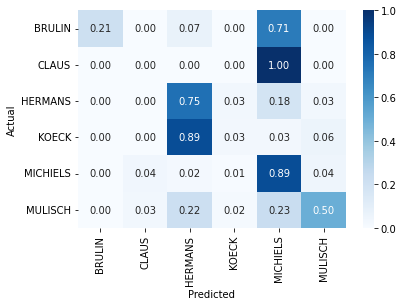

	
100 most important/characteristic TF-IDF weighted character 3-grams per author for Essays:
	
BRULIN:	  . ,  le, ton, es , het, le ,  th, n e, et , . e, te , en , dez,  en, one, akt,  to, t t, . h, on , ud , e d, ur , nge, een, men, eze, the,  ee,  ar, nt ,  so, n ., n v, re , les, ate, est, kte, is , lle, ion, nee, eur, ara,  sa, van, ekt, un ,  de,  te, t l, . a, s .,  va, ne , stu, n a, lf , n s, ont,  is, ire, e ., spe, e l,  he, ze , eed, lev, ieu, il , eel, e e, n p, , d, ter, cha, tre,  br,  po, ing, che, res, s e, t s, ns , r l, e a, bre, art,  on, din, s t, eid, n t, ore,  mo, tot, len

CLAUS:	 en , de ,  me, ppe,  in, ken,  va, van, hil, ij , ild, bee, vor, app, lde,  na, ure, eld, , e, eri, e m, n d,  el,  ra, e c, ndi, wij, chi, ons, elk, uur, ten, el , con, kte,  ( , n m, met, lke, naa, ope, ion,  ) ,  ; , tan, erd, tek, kle, ena, ies, lie, as , ond, n c, tuu, uid, kke, 's ,  kl, orm, sta,  hu, nat,  co,  en, pel, am , nse, dru, eke,  's,  on, kt , ote, hun,  ke, in ,  wi

In [21]:
essays = intra_genre[intra_genre['genre']=='Essays']
texts = set(essays['title'])

gold, silver = [], []

for text in texts:
    #print(text)
    train_df = essays[essays['title'] != text]
    test_df = essays[essays['title'] == text]
    
    vectorizer = TfidfVectorizer(max_features=1000, 
                                 analyzer='char',
                                 ngram_range=(3,3),
                                 min_df = 5).fit(train_df['segment'])
                                 ## empty samples if 'max_features' =/= 'segment_length' !
        
    vectorizer.fit(train_df['segment'])
    
    train_X = vectorizer.transform(train_df['segment'])
    train_y = train_df['author']
    
    test_X = vectorizer.transform(test_df['segment'])
    test_y = test_df['author']
    
    clf = LinearSVC(random_state=42).fit(train_X, train_y)
    
    gold.extend(test_y)
    silver.extend(clf.predict(test_X))
    

assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Essays -> Essays: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('intra_essays.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important/characteristic TF-IDF weighted character 3-grams per author for Essays:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**As with plays, the intra-genre results for essays are surprisingly poor. This is no doubt related to the fact that litttle to no texts are attributed to some of the authors. As to why, one possible factor may be text length and the added problem of cross-topic interference (more so compared to the other genres/texts in this corpus, at least).**

## Cross-genre AA with "leave-one-genre-out" cross-validation

In [22]:
cross_genre = intra_genre.copy()
cross_genre.sample(5)

,author,genre,title,segment,idx
1586,CLAUS,Toneel,bruidindemorgen,hier komt logeren ? de moeder Ja . Jij toch oo...,7
1304,CLAUS,Proza,belladonna,geweest . Het werd geschreven door Axel den Do...,13
382,CLAUS,Essays,posada,"annalen komt voor in 1135 , bij de kroning van...",29
2977,KOECK,Proza,irishmist,mogelijk dat hij zelfs een uitbrander riskeert...,67
1674,BRULIN,Essays,borstbeeld,"pièce de H. Grau , où il joue une sorte d'inca...",3


In [23]:
## check class distributions --> randomly downsampled above, so let's keep that consistent
intra_genre_dist=intra_genre[['author','segment']].groupby('author').count().reset_index()
intra_genre_dist.columns=['author','count']
intra_genre_dist['percentage']=(intra_genre_dist['count']/intra_genre_dist['count'].sum())*100
intra_genre_dist

,author,count,percentage
0,BRULIN,278,16.666667
1,CLAUS,278,16.666667
2,HERMANS,278,16.666667
3,KOECK,278,16.666667
4,MICHIELS,278,16.666667
5,MULISCH,278,16.666667


### Cross-genre: Proza -> Toneel

              precision    recall  f1-score   support

      BRULIN       0.59      0.96      0.73       138
       CLAUS       0.71      0.37      0.48        41
     HERMANS       0.48      0.72      0.57        32
       KOECK       0.75      0.16      0.26        75
    MICHIELS       0.71      0.43      0.53        28
     MULISCH       0.53      0.37      0.43        49

    accuracy                           0.59       363
   macro avg       0.63      0.50      0.50       363
weighted avg       0.63      0.59      0.54       363

	
Macro F1-score Proza -> Toneel: 0.5030737713097067
	


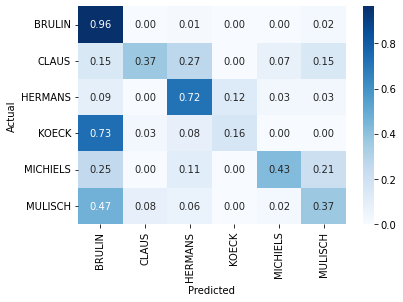

	
100 most important TF-IDF weighted character 3-grams per author for Proza -> Toneel:
	
BRULIN:	  . , n .,  ( ,  ) , van,  va, . e, . ',  ee, en ,  je, me ,  on, ie , . m, de , an , . z, e v,  pi, , d,  za, hem, em ,  be,  he,  ma, n v, nge,  en, ke , . h, was, als,  me, t .,  sp, as , we , e b, dro,  ve,  ! , ls , mer, cht, ze , ikk, ach, pie, ing, dig, rst,  po, ver, os , om , ake, heb, : ', e o, ied, zal, e g, eid, zak,  .., .. , g ., se , bew, ge , t j, had, oer, dac, oos, rot, baa, bes, on , dra, s e, ont,  'i,  to, ben, eb , ch , spr, nde,  bl, erl, rom, ! ', erb, wie, uch, e z, n p

CLAUS:	  ' , ij , zij,  , ,  zi, ' d, ge ,  ge,  in, van, e ,,  va, ' h,  sc,  lo, ft , rig, , i, eft, is ,  wi, ter, in , ren, el , ari, uis, eef,  vl, auw, nge, ler, n i, rie, n d, wan, ' z,  ro, nze, ran, rs , tte, j h, zeg, dit, ons,  ti, , h, ers, ls ,  on, e l, t g, tje, j z, ong, ie , , g,  ja, ine, kla, , a, n h,  ha, t z, ors,  co, onz, mij, . z, jon, lag, haa,  ka, r ., oet,  la, har,  ma,

In [27]:
train_df = cross_genre[cross_genre['genre']=='Proza']
test_df = cross_genre[cross_genre['genre']=='Toneel']

vectorizer = TfidfVectorizer(max_features=1000,
                             analyzer='char',
                             ngram_range=(3,3),
                             min_df = 5).fit(train_df['segment'])

train_X = vectorizer.transform(train_df['segment'])
train_y = train_df['author']

test_X = vectorizer.transform(test_df['segment'])
test_y = test_df['author']

clf = LinearSVC(random_state=42).fit(train_X, train_y)

gold = test_y
silver = clf.predict(test_X)


assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Proza -> Toneel: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cross_proza_toneel.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important TF-IDF weighted character 3-grams per author for Proza -> Toneel:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

### Cross-genre: Toneel -> Proza

              precision    recall  f1-score   support

      BRULIN       0.46      0.86      0.60       126
       CLAUS       0.28      0.20      0.23       219
     HERMANS       0.43      0.06      0.10       153
       KOECK       0.85      0.27      0.41       167
    MICHIELS       0.73      0.14      0.24       113
     MULISCH       0.29      0.82      0.43       165

    accuracy                           0.38       943
   macro avg       0.51      0.39      0.34       943
weighted avg       0.48      0.38      0.33       943

	
Macro F1-score Toneel -> Proza: 0.3356477271564491
	


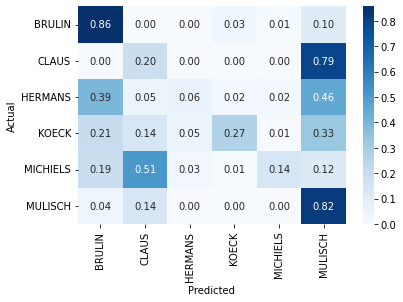

	
100 most important TF-IDF weighted character 3-grams per author for Toneel -> Proza:
	
BRULIN:	 . (, en ,  po, r :, rne, le , ..., ern, kur, t :, me ,  je,  ga,  : , ner,  ( , .. ,  ..,  ) ,  be, n .,  kl, rie, uto, de , . g, hei, ies, ing, ale, ere, lin, ees,  en, wis, lde, hil, wer, ank,  me, urt,  ee, enk, dre, oit, n v, . k,  u ,  ka, gee, is ,  fr, rli, . l,  mi, kar, ris, ele, per,  lo, kam, as , mis, art, den,  ja, iek,  du, ein, . ),  an, ull,  ik, eur,  se, les, er , jk , ers, ek ,  pe, zel, . p,  is, lot,  di, erl, n j, ie , : w, : j, ee , ijs,  va,  sp, il , ild, bew,  on, spi

CLAUS:	  [ ,  ] , ij ,  , , moe, rma,  en,  mo,  mi,  zi, zij, oer, jon, mij, de , erm, n ,,  ki, der, ong, e j, dre,  ou, ild,  jo, oed, e m,  ba, ou , vad,  ho, man,  gi,  ja,  co, . m, en , naa, nge, nne, n i, n n, dag,  ra, jn , . d, . b, ede, ant, an ,  na, j z, hoe,  hu, ron, je , haa, n g,  de, , n, , j,  hi, inn, til, , k, aro,  ro, ten, j d, ore, erv, . k, in , ? d, . t, ndr, , b, ate,  sc,

In [28]:
train_df = cross_genre[cross_genre['genre']=='Toneel']
test_df = cross_genre[cross_genre['genre']=='Proza']

vectorizer = TfidfVectorizer(max_features=1000,
                             analyzer='char',
                             ngram_range=(3,3),
                             min_df = 5).fit(train_df['segment'])

train_X = vectorizer.transform(train_df['segment'])
train_y = train_df['author']

test_X = vectorizer.transform(test_df['segment'])
test_y = test_df['author']

clf = LinearSVC(random_state=42).fit(train_X, train_y)

gold = test_y
silver = clf.predict(test_X)


assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Toneel -> Proza: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cross_toneel_proza.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important TF-IDF weighted character 3-grams per author for Toneel -> Proza:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**Reversing the directionality singificantly decreases performance in terms of macro F1-score. Results are notably worse compared to the previous cross-genre pairing, where the genres in train and test were inverted. More importantly perhaps, overall performance is quite poor in both cases, illustrating the complexity of cross-domain (i.e. genre and/or topic) authorship attribution.**

### Cross-genre: Proza -> Essays

              precision    recall  f1-score   support

      BRULIN       0.29      1.00      0.44        14
       CLAUS       0.12      0.44      0.19        18
     HERMANS       0.57      0.77      0.66        93
       KOECK       0.82      0.75      0.78        36
    MICHIELS       0.82      0.17      0.28       137
     MULISCH       0.77      0.73      0.75        64

    accuracy                           0.53       362
   macro avg       0.57      0.65      0.52       362
weighted avg       0.69      0.53      0.51       362

	
Macro F1-score Proza -> Essays: 0.5180243916328647
	


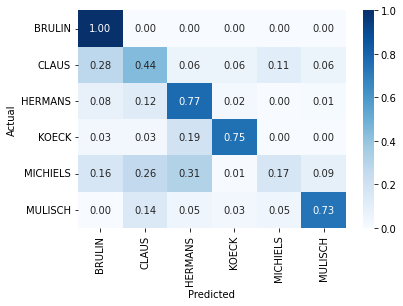

	
100 most important TF-IDF weighted character 3-grams per author for Proza -> Essays:
	
BRULIN:	  . , n .,  ( ,  ) , van,  va, . e, . ',  ee, en ,  je, me ,  on, ie , . m, de , an , . z, e v,  pi, , d,  za, hem, em ,  be,  he,  ma, n v, nge,  en, ke , . h, was, als,  me, t .,  sp, as , we , e b, dro,  ve,  ! , ls , mer, cht, ze , ikk, ach, pie, ing, dig, rst,  po, ver, os , om , ake, heb, : ', e o, ied, zal, e g, eid, zak,  .., .. , g ., se , bew, ge , t j, had, oer, dac, oos, rot, baa, bes, on , dra, s e, ont,  'i,  to, ben, eb , ch , spr, nde,  bl, erl, rom, ! ', erb, wie, uch, e z, n p

CLAUS:	  ' , ij , zij,  , ,  zi, ' d, ge ,  ge,  in, van, e ,,  va, ' h,  sc,  lo, ft , rig, , i, eft, is ,  wi, ter, in , ren, el , ari, uis, eef,  vl, auw, nge, ler, n i, rie, n d, wan, ' z,  ro, nze, ran, rs , tte, j h, zeg, dit, ons,  ti, , h, ers, ls ,  on, e l, t g, tje, j z, ong, ie , , g,  ja, ine, kla, , a, n h,  ha, t z, ors,  co, onz, mij, . z, jon, lag, haa,  ka, r ., oet,  la, har,  ma,

In [29]:
train_df = cross_genre[cross_genre['genre']=='Proza']
test_df = cross_genre[cross_genre['genre']=='Essays']

vectorizer = TfidfVectorizer(max_features=1000,
                             analyzer='char',
                             ngram_range=(3,3),
                             min_df = 5).fit(train_df['segment'])

train_X = vectorizer.transform(train_df['segment'])
train_y = train_df['author']

test_X = vectorizer.transform(test_df['segment'])
test_y = test_df['author']

clf = LinearSVC(random_state=42).fit(train_X, train_y)

gold = test_y
silver = clf.predict(test_X)


assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Proza -> Essays: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cross_proza_essays.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important TF-IDF weighted character 3-grams per author for Proza -> Essays:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**One could expect genres that are more similar to one another (e.g., running prose & essays) to increase cross-genre authorship attribution performance. However, the macro F1-score is (almost) the same as when the model was trained on prose to attribute athorship to theater plays, a genre that is arguably more different from literary prose compared to essays. On the other hand, one could also make the opposite claim that novels are closer to plays in that both tend to be longer and contain direct speech to a greater or lesser extent (whereas essays contain little to none), etc. This suggests that genre similarity only has a minimal impact within this corpus. In other words, there seems to be little to no correlation between genres that are easily confused for one another – e.g., theater olays get mistaken relatively often for literary prose in the confusion matrix of the genre classification experiment above – and cross-genre authorship attribution success. At least, not in the current experimental setup.**

### Cross-genre: Essays -> Proza

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      BRULIN       0.00      0.00      0.00       126
       CLAUS       0.22      0.01      0.02       219
     HERMANS       0.28      0.48      0.35       153
       KOECK       0.27      0.56      0.37       167
    MICHIELS       0.47      0.58      0.52       113
     MULISCH       0.43      0.48      0.45       165

    accuracy                           0.33       943
   macro avg       0.28      0.35      0.28       943
weighted avg       0.28      0.33      0.27       943

	
Macro F1-score Essays -> Proza: 0.28453002585203163
	


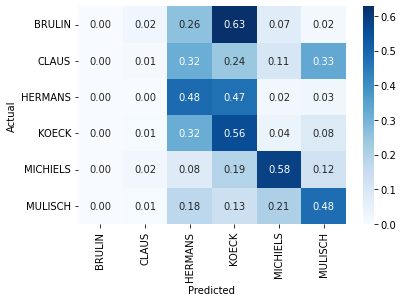

	
100 most important TF-IDF weighted character 3-grams per author for Essays -> Proza:
	
BRULIN:	  . ,  le, ton, es , het, le ,  th, n e, et , . e, te ,  en, one, dez, en , akt,  to, . h, t t, on , ur , een, e d, eze, nge, nt ,  ar,  ee, ud , n v, les, the,  so, men, n ., kte, ate, est, re ,  de, is , ion, nee, lle, ara, eur, ekt,  sa, van, t l, un , . a,  te,  va, s ., n a, ne , stu, lf , ont, spe, ire, e ., n s, eed, ter,  is, ze , , d, ieu, lev,  he, il , e l, eel, n p, e e, ing, tre,  po,  br, s l, ns ,  on, cha, t s, e a, r l, res, din, s e, eid, che, bre, art, n t, s t,  mo,  se, ore

CLAUS:	 en , de ,  me,  in, ken,  va, ppe, van, hil, ild, bee, ij , vor, app, lde,  na, , e, wij, eld, e c, n d, ure, ndi,  el, e m, ons, uur, kte, elk, chi, el ,  ra, n m, eri,  ; , naa, ten, met, tek, ion, con, ope, tan, kle, lke,  on,  ( , ena, tuu, kke, orm, n c, lie, erd, ies,  en,  kl,  hu, ond,  ) , uid, eke, as , mel, pel, nat, 's , kt ,  co, tee, dru, zic, sta,  wi,  ke, in , nse, aak, am ,

In [30]:
train_df = cross_genre[cross_genre['genre']=='Essays']
test_df = cross_genre[cross_genre['genre']=='Proza']

vectorizer = TfidfVectorizer(max_features=1000,
                             analyzer='char',
                             ngram_range=(3,3),
                             min_df = 5).fit(train_df['segment'])

train_X = vectorizer.transform(train_df['segment'])
train_y = train_df['author']

test_X = vectorizer.transform(test_df['segment'])
test_y = test_df['author']

clf = LinearSVC(random_state=42).fit(train_X, train_y)

gold = test_y
silver = clf.predict(test_X)


assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Essays -> Proza: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cross_essays_proza.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important TF-IDF weighted character 3-grams per author for Essays -> Proza:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**Though results may be inconclusive in this case, directionality seems to have a much bigger impact than any suposed similarities between genres. Similar to the case of plays to prose, using essays as the training genre for attributing novel authorship leads to a similarly significant decrease in macro F1-score. It should be noted that no predictions were made for Brulin nor Claus, which may suggest that essays are more problematic than plays in this cross-domain AA setting for some reason (e.g., no DS, shorter texts about a particular topic, cross-topic changes on top of cross-genre changes, etc.)**

### Cross-genre: Essays -> Toneel

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      BRULIN       0.00      0.00      0.00       138
       CLAUS       0.50      0.02      0.05        41
     HERMANS       0.31      0.34      0.32        32
       KOECK       0.25      0.91      0.39        75
    MICHIELS       0.35      0.39      0.37        28
     MULISCH       0.48      0.22      0.31        49

    accuracy                           0.28       363
   macro avg       0.31      0.32      0.24       363
weighted avg       0.23      0.28      0.18       363

	
Macro F1-score Essays -> Toneel: 0.24025692249574512
	


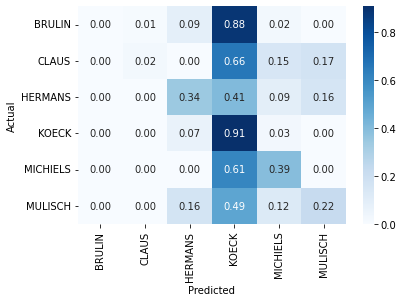

	
100 most important TF-IDF weighted character 3-grams per author for Essays -> Toneel:
	
BRULIN:	  . ,  le, ton, es , het, le ,  th, n e, et , . e, te ,  en, one, dez, en , akt,  to, . h, t t, on , ur , een, e d, eze, nge, nt ,  ar,  ee, ud , n v, les, the,  so, men, n ., kte, ate, est, re ,  de, is , ion, nee, lle, ara, eur, ekt,  sa, van, t l, un , . a,  te,  va, s ., n a, ne , stu, lf , ont, spe, ire, e ., n s, eed, ter,  is, ze , , d, ieu, lev,  he, il , e l, eel, n p, e e, ing, tre,  po,  br, s l, ns ,  on, cha, t s, e a, r l, res, din, s e, eid, che, bre, art, n t, s t,  mo,  se, ore

CLAUS:	 en , de ,  me,  in, ken,  va, ppe, van, hil, ild, bee, ij , vor, app, lde,  na, , e, wij, eld, e c, n d, ure, ndi,  el, e m, ons, uur, kte, elk, chi, el ,  ra, n m, eri,  ; , naa, ten, met, tek, ion, con, ope, tan, kle, lke,  on,  ( , ena, tuu, kke, orm, n c, lie, erd, ies,  en,  kl,  hu, ond,  ) , uid, eke, as , mel, pel, nat, 's , kt ,  co, tee, dru, zic, sta,  wi,  ke, in , nse, aak, am 

In [31]:
train_df = cross_genre[cross_genre['genre']=='Essays']
test_df = cross_genre[cross_genre['genre']=='Toneel']

vectorizer = TfidfVectorizer(max_features=1000,
                             analyzer='char',
                             ngram_range=(3,3),
                             min_df = 5).fit(train_df['segment'])

train_X = vectorizer.transform(train_df['segment'])
train_y = train_df['author']

test_X = vectorizer.transform(test_df['segment'])
test_y = test_df['author']

clf = LinearSVC(random_state=42).fit(train_X, train_y)

gold = test_y
silver = clf.predict(test_X)


assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Essays -> Toneel: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cross_essays_toneel.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important TF-IDF weighted character 3-grams per author for Essays -> Toneel:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

**Using the genres that arguably differ the most (save text length) results in predictably bad performance. Interestingly, however, results are still slightly better than those for `Proza > Toneel` (see above), which is can perhaps be partially explained by the fact that theater plays were relatively often confused with literary prose/novels (see first experiment).**

### Cross-genre: Toneel -> Essays

              precision    recall  f1-score   support

      BRULIN       0.10      1.00      0.19        14
       CLAUS       0.15      0.11      0.13        18
     HERMANS       0.46      0.30      0.36        93
       KOECK       1.00      0.28      0.43        36
    MICHIELS       1.00      0.02      0.04       137
     MULISCH       0.38      0.83      0.52        64

    accuracy                           0.30       362
   macro avg       0.52      0.42      0.28       362
weighted avg       0.68      0.30      0.26       362

	
Macro F1-score Toneel -> Essays: 0.28008188534622647
	


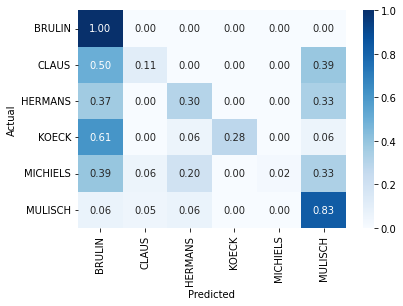

	
100 most important TF-IDF weighted character 3-grams per author for Toneel -> Essays:
	
BRULIN:	 . (, en ,  po, r :, rne, le , ..., ern, kur, t :, me ,  je,  ga,  : , ner,  ( , .. ,  ..,  ) ,  be, n .,  kl, rie, uto, de , . g, hei, ies, ing, ale, ere, lin, ees,  en, wis, lde, hil, wer, ank,  me, urt,  ee, enk, dre, oit, n v, . k,  u ,  ka, gee, is ,  fr, rli, . l,  mi, kar, ris, ele, per,  lo, kam, as , mis, art, den,  ja, iek,  du, ein, . ),  an, ull,  ik, eur,  se, les, er , jk , ers, ek ,  pe, zel, . p,  is, lot,  di, erl, n j, ie , : w, : j, ee , ijs,  va,  sp, il , ild, bew,  on, spi

CLAUS:	  [ ,  ] , ij ,  , , moe, rma,  en,  mo,  mi,  zi, zij, oer, jon, mij, de , erm, n ,,  ki, der, ong, e j, dre,  ou, ild,  jo, oed, e m,  ba, ou , vad,  ho, man,  gi,  ja,  co, . m, en , naa, nge, nne, n i, n n, dag,  ra, jn , . d, . b, ede, ant, an ,  na, j z, hoe,  hu, ron, je , haa, n g,  de, , n, , j,  hi, inn, til, , k, aro,  ro, ten, j d, ore, erv, . k, in , ? d, . t, ndr, , b, ate,  sc

In [32]:
train_df = cross_genre[cross_genre['genre']=='Toneel']
test_df = cross_genre[cross_genre['genre']=='Essays']

vectorizer = TfidfVectorizer(max_features=1000,
                             analyzer='char',
                             ngram_range=(3,3),
                             min_df = 5).fit(train_df['segment'])

train_X = vectorizer.transform(train_df['segment'])
train_y = train_df['author']

test_X = vectorizer.transform(test_df['segment'])
test_y = test_df['author']

clf = LinearSVC(random_state=42).fit(train_X, train_y)

gold = test_y
silver = clf.predict(test_X)


assert len(gold) == len(silver)
print(classification_report(gold, silver))
print('\t')
print(f"Macro F1-score Toneel -> Essays: {f1_score(gold, silver, average='macro')}")
print('\t')

cm = confusion_matrix(gold, silver)
## normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cross_toneel_essays.png', bbox_inches='tight')
plt.show(block=False);

print('\t')
print('100 most important TF-IDF weighted character 3-grams per author for Toneel -> Essays:')
print('\t')
print_top_feats(vectorizer, clf, clf.classes_)

## Plot: How do commonly confused genres affect cross-genre AA?

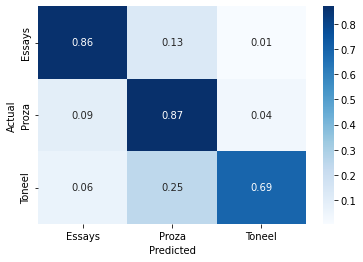

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

## normalize
genre_cmn = genre_cm.astype('float') / genre_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(genre_cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=genre_clf.classes_, yticklabels=genre_clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

In [39]:
results = []

labels = genre_clf.classes_

for i, l1 in enumerate(sorted(labels)):
    for j, l2 in enumerate(sorted(labels)):
        results.append((l1 + ' -> ' + l2, genre_cmn[i, j]))
        
results = pd.DataFrame(results, columns=('GENRES', 'GC_F1_SCORES')) ## F1-scores

## I assume these should be the 'avg macro f1-scores' from each classification report?
results['AA_F1_MACRO'] = [0.4030780100860492,  ## Essays -> Essays
                          0.28453002585203163, ## Essays -> Proza
                          0.24025692249574512, ## Essays -> Toneel
                          0.5180243916328647,  ## Proza  -> Essays
                          0.6290024084002775,  ## Proza  -> Proza
                          0.5030737713097067,  ## Proza  -> Toneel
                          0.28008188534622647, ## Toneel -> Essays
                          0.3356477271564491,  ## Toneel -> Proza
                          0.5863320382790663]  ## Toneel -> Toneel
results

,GENRES,GC_F1_SCORES,AA_F1_MACRO
0,Essays -> Essays,0.862355,0.403078
1,Essays -> Proza,0.131012,0.284530
2,Essays -> Toneel,0.006633,0.240257
3,Proza -> Essays,0.094527,0.518024
4,Proza -> Proza,0.868988,0.629002
5,Proza -> Toneel,0.036484,0.503074
6,Toneel -> Essays,0.063018,0.280082
7,Toneel -> Proza,0.245439,0.335648
8,Toneel -> Toneel,0.691542,0.586332


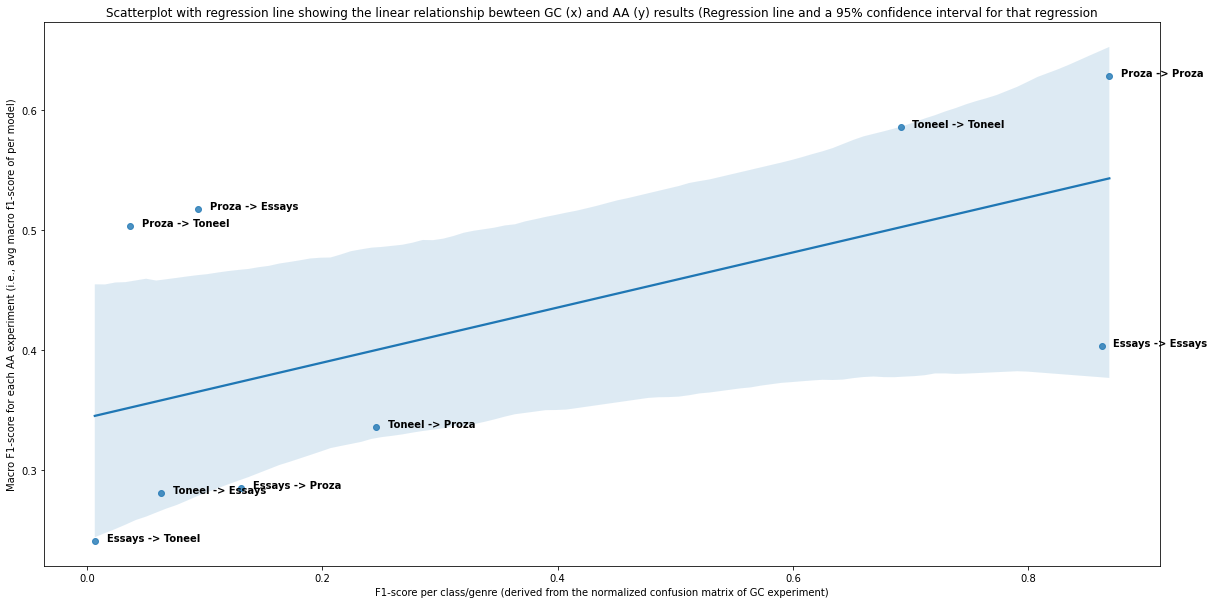

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
p1 = sns.regplot('GC_F1_SCORES', # Horizontal axis
                 'AA_F1_MACRO',  # Vertical axis
                 data=results)   # Data source
                 #,ci=None)   

for line in range(0,results.shape[0]):
     p1.text(results.GC_F1_SCORES[line]+0.01, results.AA_F1_MACRO[line], 
     results.GENRES[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.title('Scatterplot with regression line showing the linear relationship bewteen GC (x) and AA (y) results (Regression line and a 95% confidence interval for that regression)')
# Set x-axis label
plt.xlabel('F1-score per class/genre (derived from the normalized confusion matrix of GC experiment)')
# Set y-axis label
plt.ylabel('Macro F1-score for each AA experiment (i.e., avg macro f1-score per model)')

plt.savefig('scatterplot_with_regression_line.png', bbox_inches='tight')

plt.show;

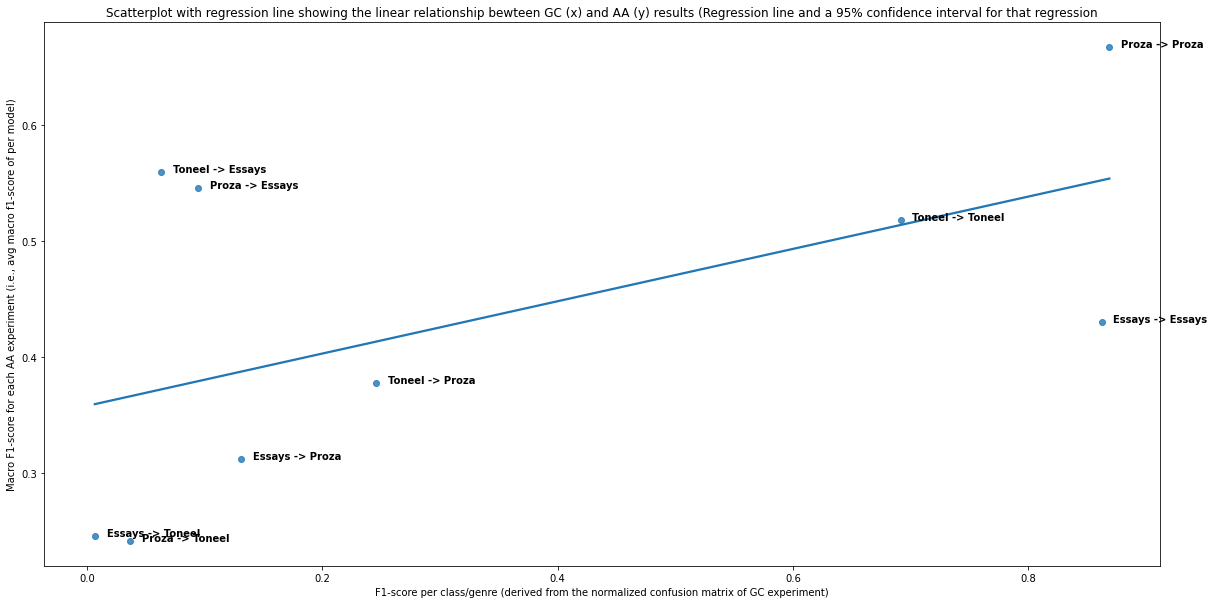

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
p1 = sns.regplot('GC_F1_SCORES', # Horizontal axis
                 'AA_F1_MACRO',  # Vertical axis
                 data=results,   # Data source
                 ci=None)
                 #,robust=True)

for line in range(0,results.shape[0]):
     p1.text(results.GC_F1_SCORES[line]+0.01, results.AA_F1_MACRO[line], 
     results.GENRES[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.title('Scatterplot with regression line showing the linear relationship bewteen GC (x) and AA (y) results')
# Set x-axis label
plt.xlabel('F1-score per class/genre (derived from the normalized confusion matrix of GC experiment)')
# Set y-axis label
plt.ylabel('Macro F1-score for each AA experiment (i.e., avg macro f1-score per model)')

plt.savefig('scatterplot_without_confidence_interval.png', bbox_inches='tight')

plt.show;